# Modifying Metadata

In this example we will show how to modify the metadata of a SDFITS file using `dysh`.

## Background

We will use a practical example. For observations with the GBT it is recommended to observe a flux density calibrator (see e.g., [Perley & Butler 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..230....7P/abstract) for a list of calibrator sources and their flux densities) with the same configuration as that used for the science observations. The reason being that the values of the temperature equivalent power of the noise diodes stored in the SDFITS files can be out of date.

In this example we won't use observations of a flux density calibrator, but instead we will use the analysis of [Goddy et al (2020)](https://ui.adsabs.harvard.edu/abs/2020RNAAS...4....3G/abstract). They find that the temperature stored in the SDFITS files is on average lower than the measured values, so that the temperature must be corrected by 20%
$$
T_{\rm{CAL,corr}}=1.2\ T_{\rm{CAL,file}}
$$
Here we use this to correct the temperature of the noise diode.

## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

      filename = dysh_data()
      sdf = GBTFITSLoad()
      sdf.select()
      sb = sdf.getps()
      ta = sb.timeaverage()
      ta.baseline()
      ta.average()
      ta.plot()
      ta_plt.savefig()


## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for working with the data.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path


## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

### Data retrieval

We download the data we will use for this example, if necessary.

In [3]:
filename = dysh_data(test="getps")

12:29:15.463 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


### Data loading

We load the data and inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


### Metadata inspection

Now we inspect the current noise diode temperature stored in the SDFITS file, and some additional related parameters.

In [6]:
sdfits["TCAL", "PLNUM", "CAL", "INTNUM"]

,TCAL,PLNUM,CAL,INTNUM
0,1.424292,1,T,0
1,1.424292,1,F,0
2,1.452650,0,T,0
3,1.452650,0,F,0
4,1.424292,1,T,1
...,...,...,...,...
347,1.452650,0,F,9
348,1.424292,1,T,10
349,1.424292,1,F,10
350,1.452650,0,T,10


For polarization 0 the noise diode temperature is 1.452650 K and for polarization 1 it is 1.424292 K.

We will calibrate the data using these values to compare after we update the noise diode temperature. We use position switching calibration, then we time average all the scans and remove an order 1 polynomial.

In [7]:
ps_original = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
ps_original.baseline(degree=1, remove=True) 

12:29:16.799 I EXCLUDING None


### Metadata update

Now we update the temperature of the noise diode by multiplying by 1.2.

In [8]:
sdfits["TCAL"] *= 1.2

/home/teuben/GBT/dysh/src/dysh/fits/gbtfitsload.py:3341: UserWarning: Changing an existing SDFITS column TCAL
  warnings.warn(f"Changing an existing SDFITS column {items}")  # noqa: B028
/home/teuben/GBT/dysh/src/dysh/fits/sdfitsload.py:1115: UserWarning: Changing an existing SDFITS column TCAL
  warnings.warn(f"Changing an existing SDFITS column {items}")  # noqa: B028


Now we check that the values were updated.

In [9]:
sdfits["TCAL", "PLNUM"]

,TCAL,PLNUM
0,1.70915,1
1,1.70915,1
2,1.74318,0
3,1.74318,0
4,1.70915,1
...,...,...
347,1.74318,0
348,1.70915,1
349,1.70915,1
350,1.74318,0


The values were updated. We proceed with the data reduction.

In [10]:
ps_updated = sdfits.getps(plnum=0, ifnum=0, fdnum=0).timeaverage()
ps_updated.baseline(degree=1, remove=True) 

12:29:17.628 I EXCLUDING None


Now plot and compare the result. Since the antenna temperature is directly proportional to the temperature of the noise diode, now the line profile after the update should be 20% brighter than without the update.

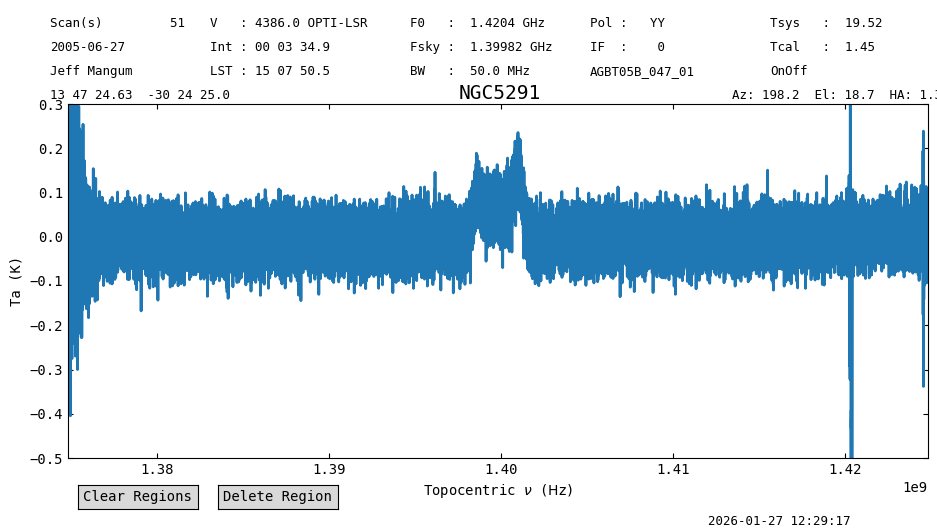

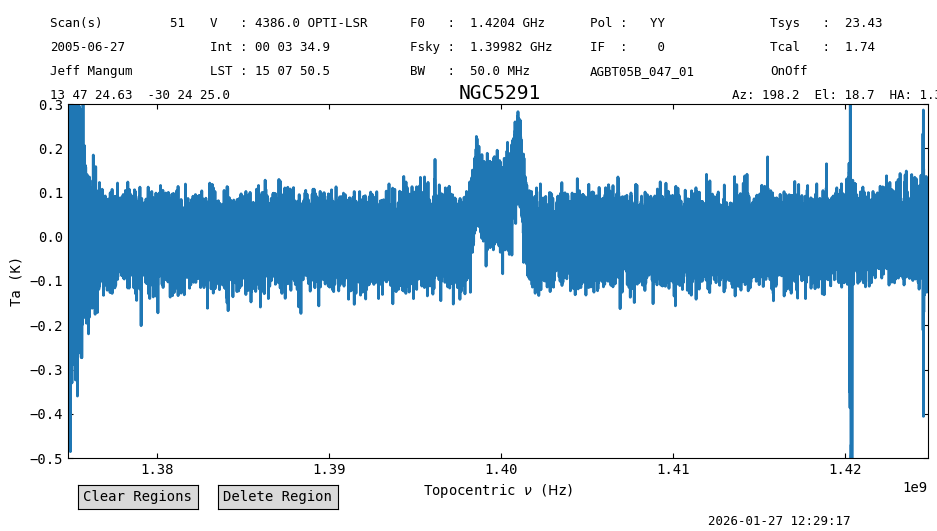

In [11]:
ps_original.plot(ymin=-0.5, ymax=0.3)
ps_updated.plot(ymin=-0.5, ymax=0.3)

## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.



In [12]:
ps_updated.stats()  # rms 0.07192832 K

{'mean': <Quantity 1.71303943e-17 K>,
 'median': <Quantity -0.00169327 K>,
 'rms': <Quantity 0.07192832 K>,
 'min': <Quantity -2.08550693 K>,
 'max': <Quantity 0.92205283 K>,
 'npt': 32768,
 'nan': 0}